# Package used in analysis download

In [1]:
# Data reading
import pandas as pd 

# Directory manipulation
import os

# Date wrangling
import datetime 

# Ploting packages 
import matplotlib.pyplot as plt 
import seaborn as sns

# Newest data download

In [2]:
# Downloading the newest data 
!python3 dataDownload.py

Read municipality data in 1.05 seconds
Rows read: 13912
Read patient data in 1.44 seconds
Rows read: 35911
Data saved in data/2020-11-17


# Reading the newest data 

In [3]:
# Listing all the directories in the data folder 
dataFolders = os.listdir('data')
dataFolders = [x for x in dataFolders if not x.endswith('.csv')]

# Converting the folder names to datetime. That way when we sort we can be sure that the 
# newest date will be the last coordinate
dataFolders = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in dataFolders]

# Sorting 
dataFolders.sort()

# Extracting the newest date 
newestDate = dataFolders[-1].strftime('%Y-%m-%d')

# Reading the newest files
dMunicipality = pd.read_csv(f'data/{newestDate}/municipality_data.csv')
dPatient = pd.read_csv(f'data/{newestDate}/patient_data.csv')

# Data cleaning and engineering 

## Municipality data 

In [4]:
print(dMunicipality.shape)

(13912, 7)


In [5]:
print(dMunicipality.head())

          day administrative_level_3  tests_negative  tests_positive  \
0  2020-03-19             Alytaus m.               2               0   
1  2020-03-19              Elektrėnų               1               0   
2  2020-03-19               Kauno m.              20               0   
3  2020-03-19               Kauno r.               1               0   
4  2020-03-19           Panevėžio r.               1               0   

   tests_positive_repeated  tests_positive_new  tests_total  
0                        0                   0            2  
1                        0                   0            1  
2                        0                   0           20  
3                        0                   0            1  
4                        0                   0            1  


In [6]:
print(dMunicipality.dtypes)

day                        object
administrative_level_3     object
tests_negative              int64
tests_positive              int64
tests_positive_repeated     int64
tests_positive_new          int64
tests_total                 int64
dtype: object


In [7]:
# Converting the day column to date format 
dMunicipality['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in dMunicipality['day']]

In [8]:
# Sorting the data frame by the date 
dMunicipality.sort_values('day', inplace=True)
dMunicipality.reset_index(inplace=True, drop=True)

# Geting unique day count 
uniqueDates = list(set(dMunicipality['day']))

In [9]:
print(f'Number of unique days in the dataset: {len(uniqueDates)}')
print(f'First day in data: {min(uniqueDates)}')
print(f'Newest day in data: {max(uniqueDates)}')

Number of unique days in the dataset: 242
First day in data: 2020-03-19
Newest day in data: 2020-11-15


In [10]:
# Geting unique municipality names
uniqueMun = list(set(dMunicipality['administrative_level_3']))

In [11]:
print(f'Number of unique municipalities in the dataset: {len(uniqueMun)}')

Number of unique municipalities in the dataset: 60


 # Patient level data

In [12]:
print(dPatient.shape)

(35911, 12)


In [13]:
print(dPatient.head())

   actual_day         day imported              country    status foreigner  \
0  2020-02-25  2020-02-28     Taip  Italijos Respublika  Pasveiko        Ne   
1  2020-03-09  2020-03-10     Taip  Italijos Respublika  Pasveiko        Ne   
2  2020-03-10  2020-03-10     Taip  Italijos Respublika  Pasveiko        Ne   
3  2020-03-09  2020-03-12     Taip  Ispanijos Karalystė  Pasveiko        Ne   
4  2020-03-11  2020-03-13     Taip  Ispanijos Karalystė  Pasveiko      Taip   

     age      sex administrative_level_3 hospitalized intensive precondition  
0  30-39  Moteris             Šiaulių m.         Taip       NaN          NaN  
1  30-39    Vyras               Kauno m.         Taip       NaN          NaN  
2  30-39  Moteris               Kauno m.         Taip       NaN          NaN  
3  40-49  Moteris           Klaipėdos m.         Taip       NaN          NaN  
4  40-49  Moteris            Vilniaus m.         Taip       NaN          NaN  


In [14]:
print(dPatient.dtypes)

actual_day                object
day                       object
imported                  object
country                   object
status                    object
foreigner                 object
age                       object
sex                       object
administrative_level_3    object
hospitalized              object
intensive                 object
precondition              object
dtype: object


In [15]:
# Converting the day column to date format 
dPatient['day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in dPatient['day']]
dPatient['actual_day'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in dPatient['actual_day']]

In [16]:
# Sorting the data frame by the date 
dPatient.sort_values('day', inplace=True)
dPatient.reset_index(inplace=True, drop=True)

In [17]:
# Creating logical columns for certain boolean columns 
for col in ['imported', 'foreigner', 'hospitalized']:
    dPatient[f'is_{col}'] = [1 if x == 'Taip' else 0 for x in dPatient[col]]

In [18]:
# Creating a column for is cured
dPatient['is_cured'] = [1 if x == 'Pasveiko' else 0 for x in dPatient['status']]

# Aggregated daily trends 

In [19]:
def plot_daily_stat(statistic:str, data:pd.DataFrame, title:str, figsize=(16, 12), group=None) -> None:
    """
    Plots a given daily statistic
    """
    plt.figure(figsize=figsize)
    if group is None:
        sns.lineplot(x='day', y=statistic, marker='o', data=data)
        plt.fill_between(data['day'], data[statistic], alpha=0.4)
    else:
        sns.lineplot(x='day', y=statistic, marker='o', data=data, hue=group)
    plt.title(title)
    plt.grid()
    plt.show()

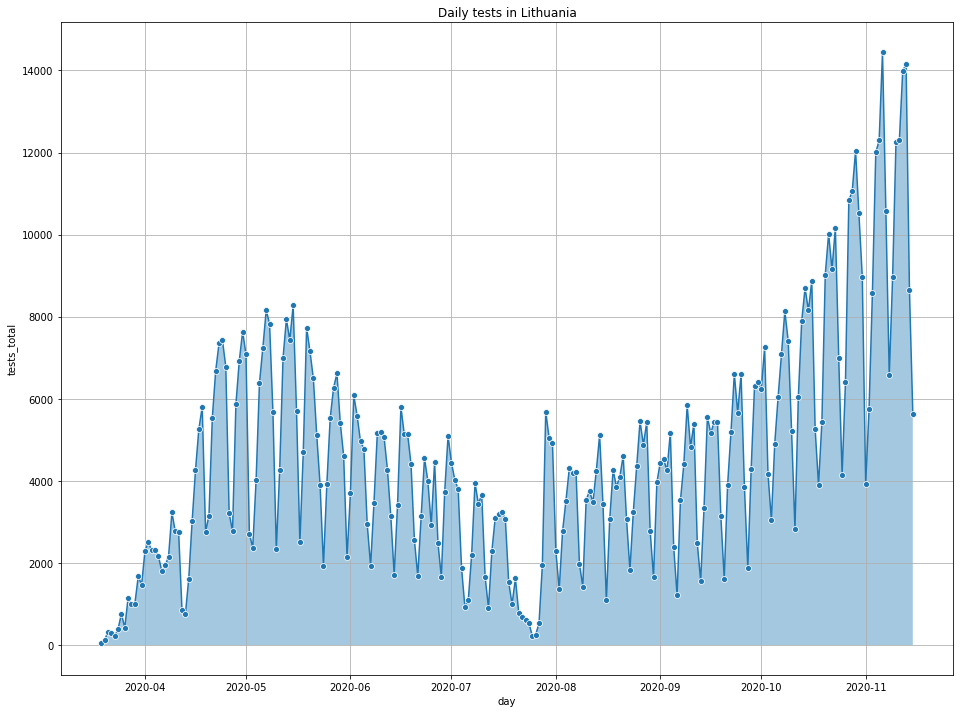

In [20]:
# Calculating daily tests 
daily_testing = dMunicipality.groupby('day', as_index=False)['tests_total'].sum()

# Ploting daily tests
plot_daily_stat(
    statistic='tests_total', 
    data=daily_testing,
    title='Daily tests in Lithuania'
)

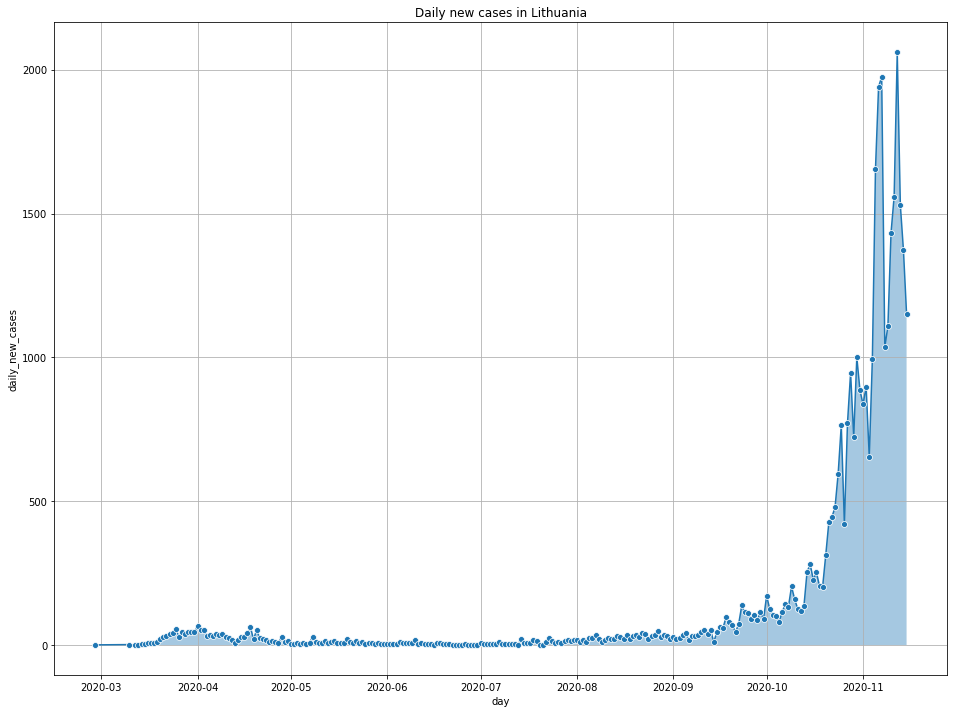

In [21]:
# Calculating daily incidents
daily_incidents = dPatient.groupby('day', as_index=False).size()
daily_incidents = daily_incidents.rename(columns={'size': 'daily_new_cases'})

# Ploting daily incidents
plot_daily_stat(
    statistic='daily_new_cases', 
    data=daily_incidents,
    title='Daily new cases in Lithuania'
)

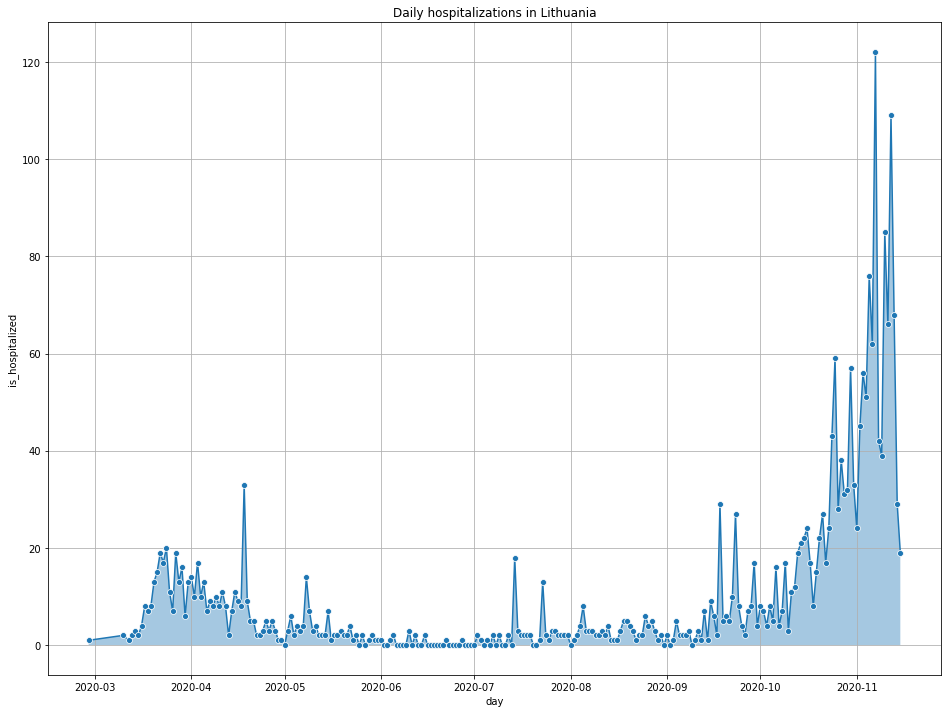

In [22]:
# Calculating an ploting daily hospitalizations
daily_hospitalizations = dPatient.groupby('day', as_index=False)['is_hospitalized'].sum()

plot_daily_stat(
    statistic='is_hospitalized', 
    data=daily_hospitalizations,
    title='Daily hospitalizations in Lithuania'
)

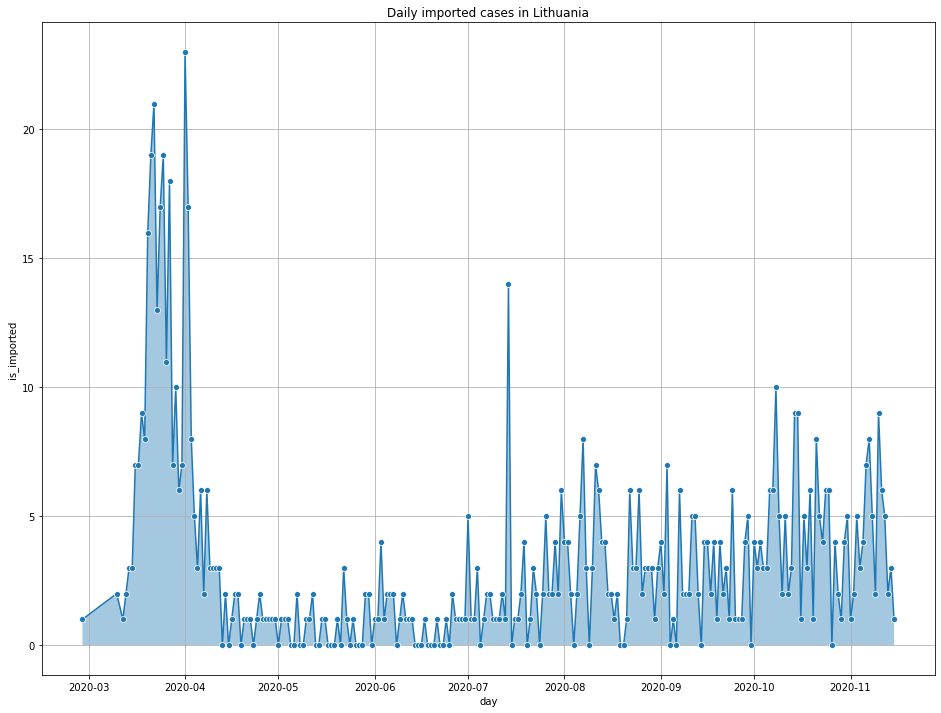

In [23]:
# Calculating an ploting daily imported cases
daily_imported = dPatient.groupby('day', as_index=False)['is_imported'].sum()

plot_daily_stat(
    statistic='is_imported', 
    data=daily_imported,
    title='Daily imported cases in Lithuania'
)

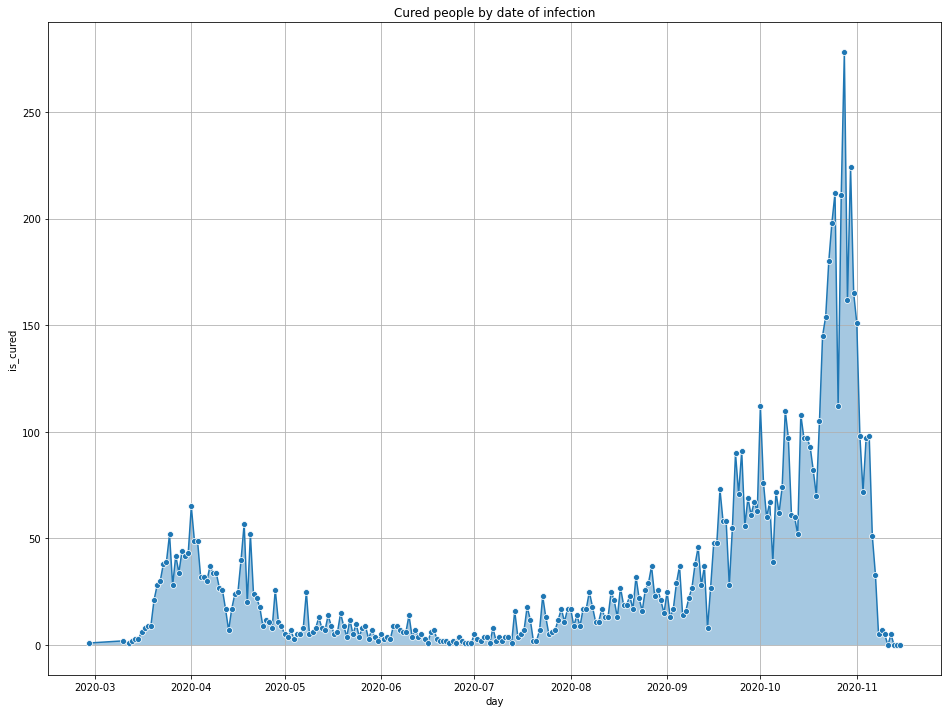

In [24]:
daily_cures = dPatient.groupby(['day'], as_index=False)['is_cured'].sum()

plot_daily_stat(
    statistic='is_cured', 
    data=daily_cures,
    title='Cured people by date of infection'
)

# Positive test share

In [25]:
# Merging the data together 
dratio = pd.merge(daily_testing, daily_incidents, on='day', how='left')

# Calculating the share of hospitalizations
dratio['percent_positive'] = dratio['daily_new_cases'] * 100 / dratio['tests_total']

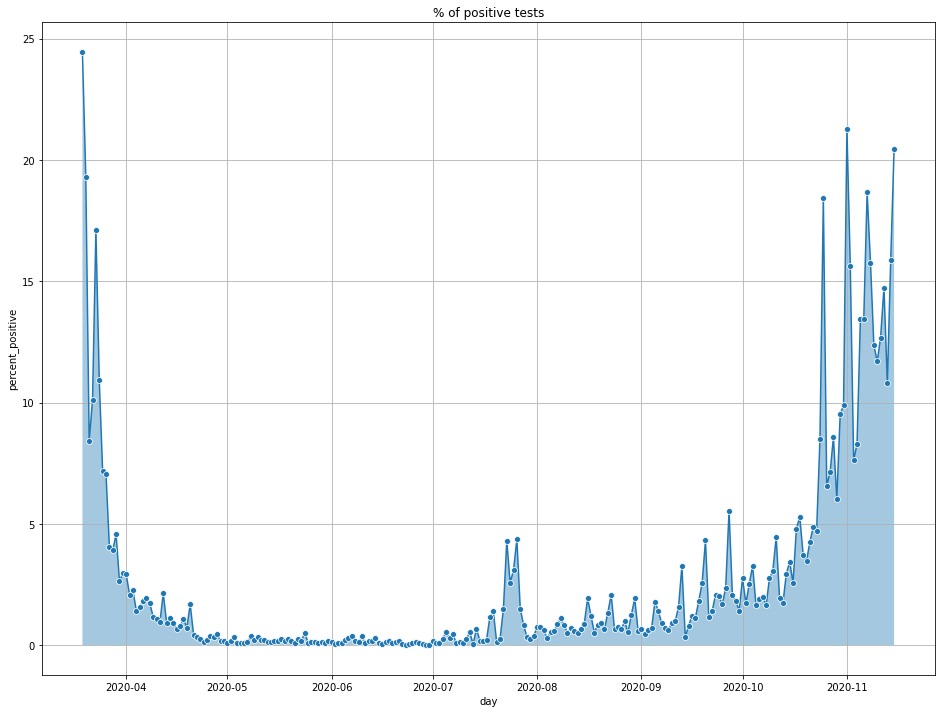

In [26]:
plot_daily_stat(
    statistic='percent_positive', 
    data=dratio,
    title='% of positive tests'
)